In [78]:
# load dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# connect to CryptoCompare API
api_key = os.environ.get("CryptoCompare_API_KEY")

In [3]:
# retrieve a list of all coins
url = f"https://min-api.cryptocompare.com/data/all/coinlist"
response = requests.get(url).json()

# convert to dataframe
crypto_list_df = pd.DataFrame(response["Data"]).transpose()

In [5]:
# get full column list
crypto_list_df.columns

Index(['Id', 'Url', 'ImageUrl', 'ContentCreatedOn', 'Name', 'Symbol',
       'CoinName', 'FullName', 'Description', 'AssetTokenStatus', 'Algorithm',
       'ProofType', 'SortOrder', 'Sponsored', 'Taxonomy', 'Rating',
       'IsTrading', 'TotalCoinsMined', 'CirculatingSupply', 'BlockNumber',
       'NetHashesPerSecond', 'BlockReward', 'BlockTime', 'AssetLaunchDate',
       'AssetWhitepaperUrl', 'AssetWebsiteUrl', 'MaxSupply', 'MktCapPenalty',
       'IsUsedInDefi', 'IsUsedInNft', 'PlatformType', 'AlgorithmType',
       'Difficulty', 'BuiltOn', 'SmartContractAddress', 'DecimalPoints'],
      dtype='object')

In [6]:
# select only the needed columns
crypto_clean = crypto_list_df.loc[:, ["Name", "Symbol", "CoinName", "TotalCoinsMined", \
                                      "AssetLaunchDate", "MktCapPenalty"]]

# visualize the new pared-down dataframe
crypto_clean.head()

,Name,Symbol,CoinName,TotalCoinsMined,AssetLaunchDate,MktCapPenalty
42,42,42,42 Coin,41.999952,2014-01-05,0
300,300,300,300 token,300,2017-07-01,0
365,365,365,365Coin,0,2017-11-17,0
404,404,404,404Coin,0,2017-10-31,0
433,433,433,433 Token,NaN,NaN,NaN


In [7]:
# investigate the number of coins available
len(crypto_clean)

8375

In [8]:
# investigate data types
crypto_clean.dtypes

Name               object
Symbol             object
CoinName           object
TotalCoinsMined    object
AssetLaunchDate    object
MktCapPenalty      object
dtype: object

In [48]:
def RetrieveDailyPrice(sym, comp_sym, all_data=True, exchange=''):
    url = "https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym={}&limit=2000"\
        .format(sym.upper(), comp_sym.upper())
    
    if exchange:
        url += f'&e={exchange}'
        
    url += f"&api_key={api_key}"
    
    response = requests.get(url)
    data = response.json()["Data"]
    
    if not data:
        return pd.DataFrame()
    
    crypto_df = pd.DataFrame(data["Data"])
        
    return crypto_df

In [58]:
cryp_dict = {}

ftx_collapse = pd.to_datetime("2022-11-11")
start = ftx_collapse - datetime.timedelta(days=14)
end = ftx_collapse + datetime.timedelta(days=14)

In [60]:
for sym in list(crypto_clean["Symbol"]):
    
    cur_sym_df = RetrieveDailyPrice(sym, "USD")
    
    if cur_sym_df.empty:
        continue
        
    else:
        cur_sym_df["time"] = pd.to_datetime(cur_sym_df["time"], unit='s')
        cur_sym_clean_df = cur_sym_df[["time", "open", "close", "low", "high"]]
        
        cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] - 
                                      cur_sym_clean_df["open"]) / cur_sym_clean_df["open"]
        
        cur_sym_nar_df = cur_sym_clean_df.loc[(cur_sym_clean_df["time"] >= start) & 
                                              (cur_sym_clean_df["time"] <= end), :]
        
        if cur_sym_nar_df.empty:
            continue
            
        else:
            cryp_dict[sym] = [cur_sym_nar_df, cur_sym_nar_df["return"].mean()]

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_38719/2058860197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] -


In [105]:
# create a dataframe and sort it by descending average daily return
# to retrieve the 25 best performing coins for the period of interest
avg_ret = [value[1] for value in cryp_dict.values()]

hi_ret_df = pd.DataFrame({"Symbol" : cryp_dict.keys(), 
                          "Coin Name" : [crypto_clean.loc[crypto_clean["Symbol"] == key, "CoinName"][0] for key in cryp_dict.keys()],
              "Average Daily Return" : [value[1] for value in cryp_dict.values()]
             }).sort_values("Average Daily Return", ascending=False).reset_index(drop=True).head(25)


pop_list = ['BTC', 'ETH', 'USDT', 'BNB', 'USDC',
            'XRP', 'BUSD', 'ADA', 'DOGE', 'MATIC',
            'SOL', 'DOT', 'LTC', 'SHIB', 'AVAX',
            'DAI', 'TRX', 'ATOM', 'LINK', 'ETC',
           'APT', 'BCH', 'APE', 'NEAR', 'FIL']

top_df = pd.DataFrame({"Symbol" : pop_list,
                       "Coin Name" : [crypto_clean.loc[crypto_clean["Symbol"] == key, "CoinName"][0] for key in pop_list]
                      })

In [106]:
hi_ret_df

,Symbol,Coin Name,Average Daily Return
0,MON,Monstock,53.382041
1,FBX,ForthBox,1.097090
2,SFT,SportsFix,0.996828
3,XBC,BitcoinPlus,0.390703
4,XSPC,SpectreSecurityCoin,0.363595
5,PHT,Photon Token,0.277516
6,IPL,VouchForMe,0.260716
7,MPRO,MediumProject,0.258578
8,DCK,DickCoin,0.232992
9,SLS,SaluS,0.203623


In [107]:
top_df

,Symbol,Coin Name
0,BTC,Bitcoin
1,ETH,Ethereum
2,USDT,Tether
3,BNB,Binance Coin
4,USDC,USD Coin
5,XRP,XRP
6,BUSD,BUSD
7,ADA,Cardano
8,DOGE,Dogecoin
9,MATIC,Polygon


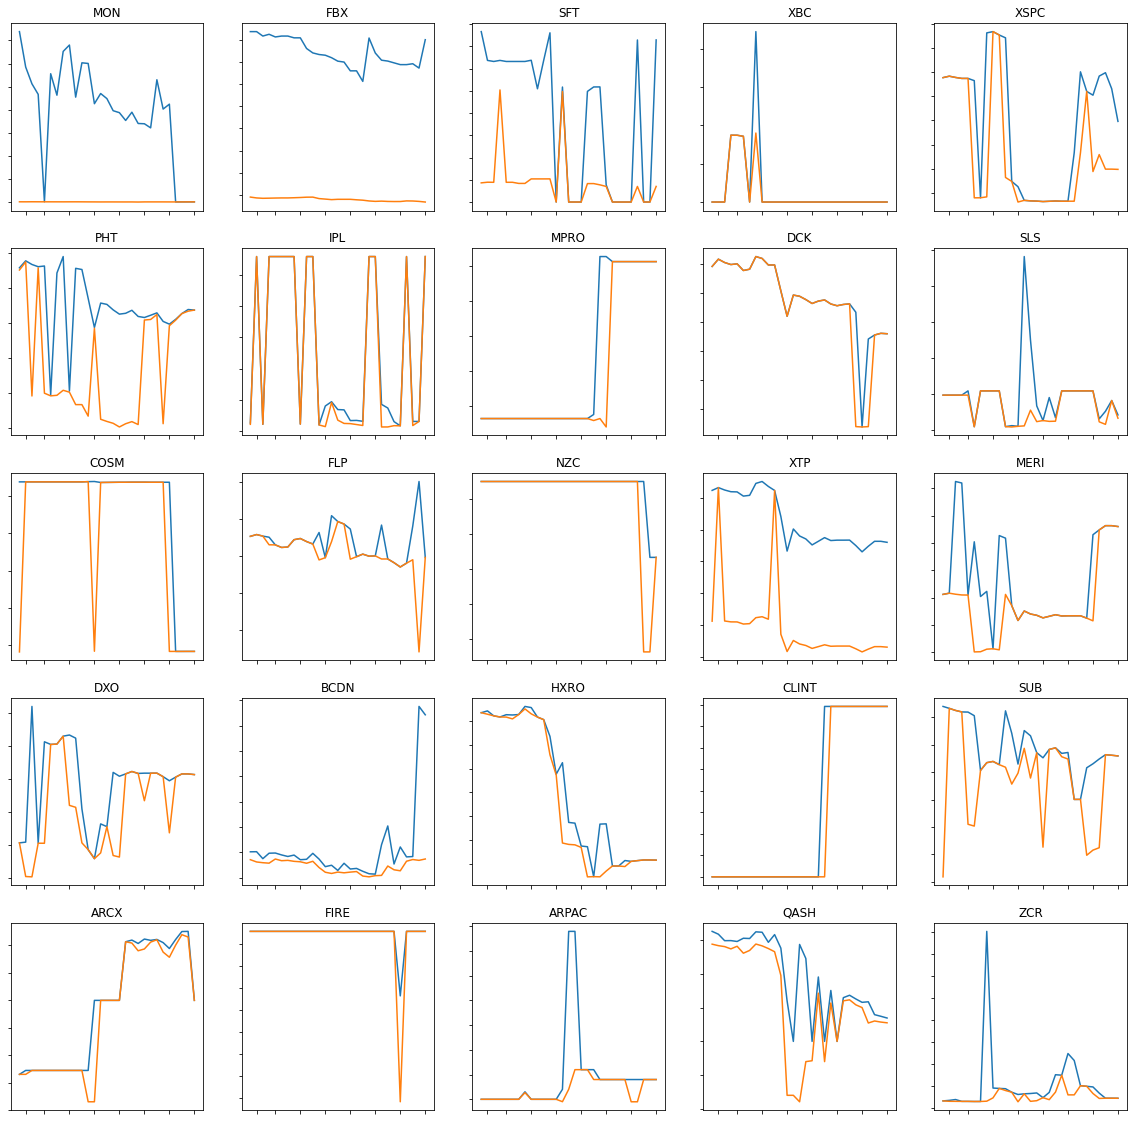

In [74]:
# initiate the figure and axis with 23 subplots in a vertical line
fig, ax = plt.subplots(5,5, figsize=(20, 20))

i = 0
j = 0

for sym in hi_ret_df["Symbol"]:
    
    ax[i, j].plot(cryp_dict[sym][0]["time"], cryp_dict[sym][0]["high"])
    ax[i, j].plot(cryp_dict[sym][0]["time"], cryp_dict[sym][0]["low"])
    ax[i, j].set_title(sym)
    ax[i, j].tick_params(which='both',      # both major and minor ticks are affected
                         right=False,
                         left=True,
                         bottom=True,      # ticks along the bottom edge are off
                         top=False,         # ticks along the top edge are off
                         labelbottom=False,
                         labelleft=False)
    
    if j < 4:
        j += 1
    else:
        i += 1
        j = 0

In [109]:
top_dict = {}

for sym in list(pop_list):
    
    cur_sym_df = RetrieveDailyPrice(sym, "USD")
    
    if cur_sym_df.empty:
        continue
        
    else:
        cur_sym_df["time"] = pd.to_datetime(cur_sym_df["time"], unit='s')
        cur_sym_clean_df = cur_sym_df[["time", "open", "close", "low", "high"]]
        
        cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] - 
                                      cur_sym_clean_df["open"]) / cur_sym_clean_df["open"]
        
        cur_sym_nar_df = cur_sym_clean_df.loc[(cur_sym_clean_df["time"] >= start) & 
                                              (cur_sym_clean_df["time"] <= end), :]
        
        if cur_sym_nar_df.empty:
            continue
            
        else:
            top_dict[sym] = cur_sym_nar_df

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_38719/2714029701.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



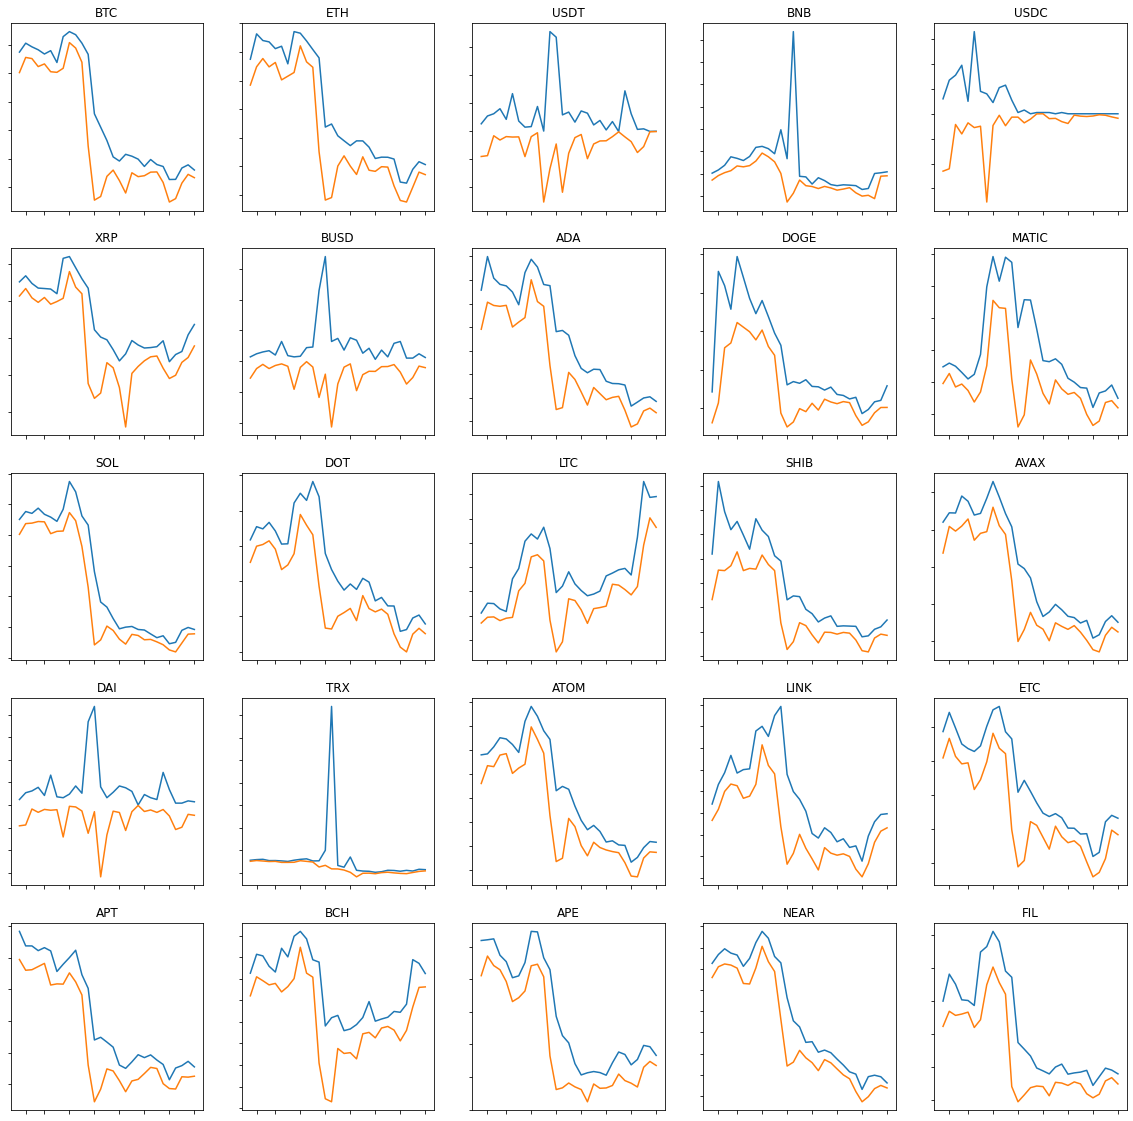

In [111]:
# initiate the figure and axis with 23 subplots in a vertical line
fig, ax = plt.subplots(5,5, figsize=(20, 20))

i = 0
j = 0

for sym in top_df["Symbol"]:
    
    ax[i, j].plot(top_dict[sym]["time"], top_dict[sym]["high"])
    ax[i, j].plot(top_dict[sym]["time"], top_dict[sym]["low"])
    ax[i, j].set_title(sym)
    ax[i, j].tick_params(which='both',      # both major and minor ticks are affected
                         right=False,
                         left=True,
                         bottom=True,      # ticks along the bottom edge are off
                         top=False,         # ticks along the top edge are off
                         labelbottom=False,
                         labelleft=False)
    
    if j < 4:
        j += 1
    else:
        i += 1
        j = 0

In [113]:
for sym in pop_list:
    
    fig = go.Figure(data=[go.Candlestick(x=top_dict[sym]["time"],
                                 open=top_dict[sym]["open"], high=top_dict[sym]["high"],
                                 low=top_dict[sym]["low"], close=top_dict[sym]["close"])], 
                    layout={'title' : f"{sym} : {crypto_clean.loc[crypto_clean['Symbol'] == sym, 'CoinName'][0]}"})
    
    fig.show()